# Default of Credit Card Clients - Predictive Models

# Outline

- Introduction
- Read data and check data structure
- Data exploration
- Data preprocessing
- Predictive models
- Model evaluation

# Introduction

This dataset contains information on credit card holders. The objective is to estimate the probability of default. 

We will talk about the content of the data.

## Load libaries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline 

import gc
from datetime import datetime 

pd.set_option('display.max_columns', 100)

import seaborn as sns
import matplotlib as mpl

from numpy import convolve

from sklearn.model_selection import train_test_split
import xgboost as xgb


import traceback
import scipy.stats.stats as stats
import re
from pandas import Series
import pandas.core.algorithms as algos
from bayes_opt import BayesianOptimization

#Ignore warnings 
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve,  roc_auc_score, precision_recall_curve
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb


## Read data and check data structure

In [2]:
data_path = './default of credit card clients.xls'
data_pd = pd.read_excel(data_path,header=[1])
print("Default Credit Card Clients data -  rows:",data_pd.shape[0]," columns:", data_pd.shape[1])
data_pd.head(5)

Default Credit Card Clients data -  rows: 30000  columns: 25


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
data_pd_des = data_pd.describe()
data_pd_des

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


## Data exploration

### Demographic factors distribution

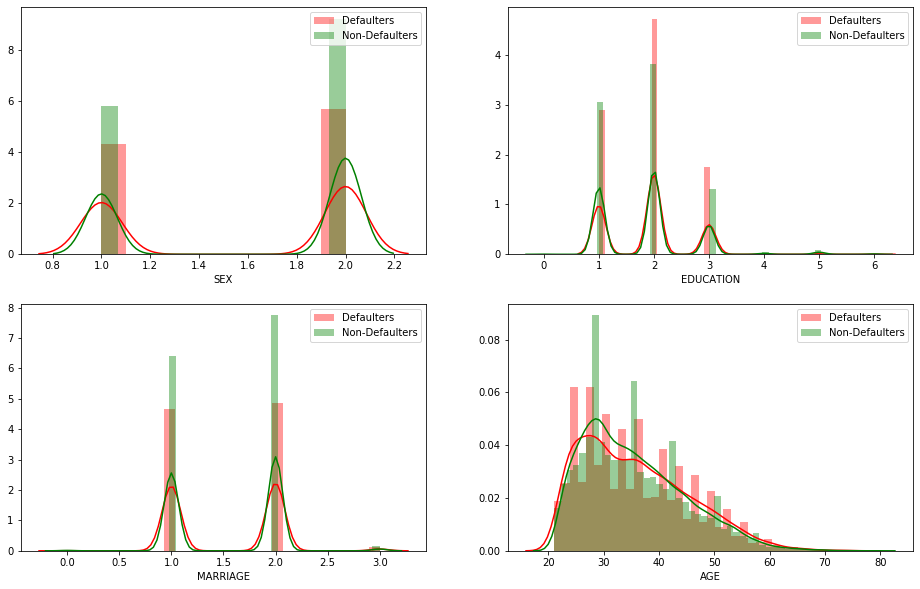

In [4]:
TARGET = 'default payment next month'
fig, axs = plt.subplots(2,2,figsize=(16,10))
demographic = ['SEX', 'EDUCATION', 'MARRIAGE', 'AGE']
for i in range(4):
    class_0 = data_pd.loc[data_pd[TARGET] == 0][demographic[i]]
    class_1 = data_pd.loc[data_pd[TARGET] == 1][demographic[i]]
    sns.distplot(class_1,kde=True, color="red",ax=axs[i//2][i%2])
    sns.distplot(class_0,kde=True, color="green",ax=axs[i//2][i%2])
    axs[i//2][i%2].legend(labels=['Defaulters','Non-Defaulters'],
           loc='upper right',bbox_to_anchor=(1, 1))
plt.show();

**Observation:** Demographic factors doesn't seem to be key differentiating factors

### Amount of credit limit distribution

Let's look at the amount of credit limit distribution for defaulters and non-defaulters.

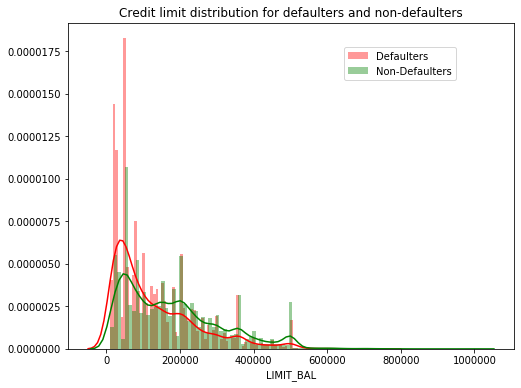

In [5]:
class_0 = data_pd.loc[data_pd[TARGET] == 0]["LIMIT_BAL"]
class_1 = data_pd.loc[data_pd[TARGET] == 1]["LIMIT_BAL"]
fig=plt.figure(figsize = (8,6))
plt.title('Credit limit distribution for defaulters and non-defaulters')
sns.set_color_codes("pastel")
sns.distplot(class_1,kde=True,bins=100, color="red")
sns.distplot(class_0,kde=True,bins=100, color="green")
fig.legend(labels=['Defaulters','Non-Defaulters'],
           loc='upper right',bbox_to_anchor=(0.8, 0.8))
plt.show();

**Observation:** Defaulter/non-defaulters ratio is larger at the lower credit limit

### Re-payment status distribution

Let's look at the Re-payment status distribution for defaulters and non-defaulters. 

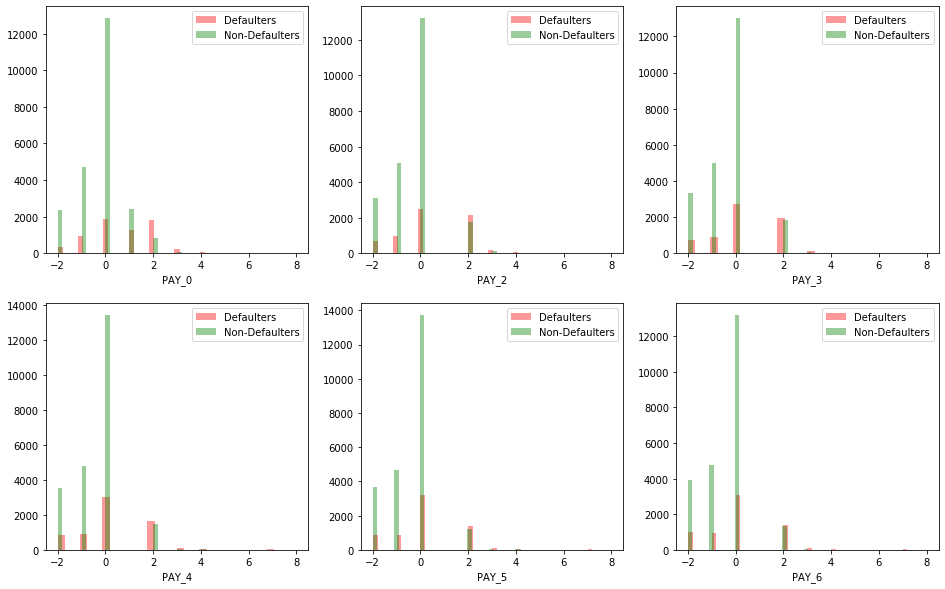

In [6]:
fig, axs = plt.subplots(2,3,figsize=(16,10))
pay_status = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

for i in range(6):
    class_0 = data_pd.loc[data_pd[TARGET] == 0][pay_status[i]]
    class_1 = data_pd.loc[data_pd[TARGET] == 1][pay_status[i]]
    sns.distplot(class_1,kde=False, color="red",ax=axs[i//3][i%3])
    sns.distplot(class_0,kde=False, color="green",ax=axs[i//3][i%3])
    axs[i//3][i%3].legend(labels=['Defaulters','Non-Defaulters'],
           loc='upper right',bbox_to_anchor=(1, 1))
plt.show();

**Observation**: Across all months, defaulters generally tend to pay two months late, non-defaulters generally pay within a month.



### Bill amount and pay amount

In [7]:
data_pd['PAY2BILL'] = (data_pd['PAY_AMT1']/(data_pd['BILL_AMT2']+1e-10)+
                       data_pd['PAY_AMT2']/(data_pd['BILL_AMT3']+1e-10)+
                       data_pd['PAY_AMT3']/(data_pd['BILL_AMT4']+1e-10)+
                       data_pd['PAY_AMT4']/(data_pd['BILL_AMT5']+1e-10)+
                       data_pd['PAY_AMT5']/(data_pd['BILL_AMT6']+1e-10))/5.0

Text(0.5, 1.0, 'PAY_AMT / BILL_AMT ratio distribution for defaulters and non-defaulters')

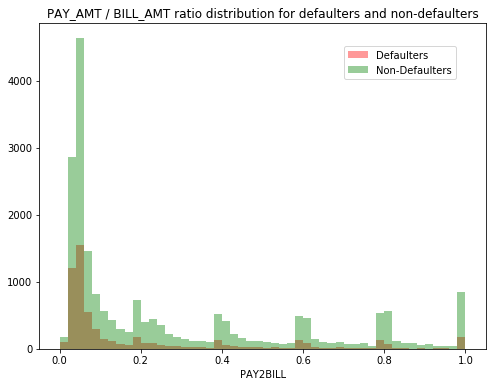

In [8]:
class_0 = data_pd.loc[(data_pd["PAY2BILL"]>0) & (data_pd["PAY2BILL"]<1) & (data_pd[TARGET] == 0)]['PAY2BILL']
class_1 = data_pd.loc[(data_pd["PAY2BILL"]>0) & (data_pd["PAY2BILL"]<1) & (data_pd[TARGET] == 1)]['PAY2BILL']
fig=plt.figure(figsize = (8,6))
plt.title('PAY_AMT / BILL_AMT ratio distribution for defaulters and non-defaulters')
sns.set_color_codes("pastel")
sns.distplot(class_1,kde=False, bins =50, color='red')
sns.distplot(class_0,kde=False, bins =50, color='green')
fig.legend(labels=['Defaulters','Non-Defaulters'],
           loc='upper right',bbox_to_anchor=(0.8, 0.8))
plt.show();
data_pd.drop(columns=['PAY2BILL'],inplace=True)

In [9]:
print('Number of samples used for the above distribution plot: ')
print('(class 0: {})'.format(len(class_0)) + ' and ' + '(class 1: {})'.format(len(class_1)))

Number of samples used for the above distribution plot: 
(class 0: 20327) and (class 1: 5783)



**Observations:**
  *  Clients tend not to pay the whole amount of the bill. Most of them are willing to pay 5% of the bill amount, and others   are willing to pay roughly 20%, 40%, 60%, 80%, and 100% of the bill amount. 
  * There is no missing value in the data
  * Education level is mostly graduate school and university
  * Average age is 35.5
  * Overall default rate is 22%, according to target variable mean
  

# Data preprocessing

## Train-validation split 

In [10]:
VALID_SIZE = 0.20 # simple validation using train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation

RANDOM_STATE = 2020

train_df, val_df = train_test_split(data_pd, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

# Make copies of the train_df and val_df for later usage.
train_df_bkp = train_df.copy()
val_df_bkp = val_df.copy()

X_train, y_train = train_df.iloc[:,1:-1], train_df.iloc[:,-1]
X_test,  y_test  = val_df.iloc[:,1:-1],  val_df.iloc[:,-1]

y_train_hist,  y_test_hist = y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

print('In the training dataset, the default rate is')
print('{:.2f}'.format(y_train_hist[1]/(y_train_hist[0]+y_train_hist[1])))
print('In the validation dataset, the default rate is')
print('{:.2f}'.format(y_test_hist[1]/(y_test_hist[0]+y_test_hist[1])))

print('The default rates are similar in the training and validation dataset')

In the training dataset, the default rate is
0.22
In the validation dataset, the default rate is
0.23
The default rates are similar in the training and validation dataset


## Feature Engineer - Weight of Evidence

We use the weight of evidence (WOE) to transform input data. WOE tells the predictive power of an independent variable in relation to the dependent variable. Since it evolved from credit scoring world, it is generally described as a measure of the separation of good and bad customers.

In [11]:
max_bin = 20
force_bin = 3

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

def woe_trans(df, final_iv):
    df_woe = df.copy(deep=True)
    for column in df.columns:
        dvar = df_woe[column]
        var_woe = final_iv[final_iv['VAR_NAME']==column][['MIN_VALUE','MAX_VALUE','WOE']]
        var_woe.reset_index(drop=True, inplace=True)
        split_list = [[var_woe['MIN_VALUE'][k], var_woe['MAX_VALUE'][k]] for k in range(len(var_woe))]
        for i in range(len(var_woe)):
            dvar[(dvar>=split_list[i][0]) & (dvar <=split_list[i][1])] = var_woe['WOE'][i]
    return df_woe

# Define a binning function for continuous independent variables
def mono_bin(Y, X, n = max_bin):
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

# Define a binning function for categorical independent variables
def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
 
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

# Fit on the train data
final_iv, IV = data_vars(X_train,y_train)

# Transform on train and test data
X_train = woe_trans(X_train, final_iv)
X_test = woe_trans(X_test, final_iv)


## Feature Engineer - Scaling

We transform features by scaling each feature to a given range based on their minimum, maximum and standard deviation.

In [12]:
mm_scaler = preprocessing.MinMaxScaler()

X_train_sc = mm_scaler.fit_transform(X_train)
X_test_sc = mm_scaler.transform(X_test)


X_train = pd.DataFrame(X_train_sc, index=X_train.index, columns=X_train.columns)
X_test  = pd.DataFrame(X_test_sc,  index=X_test.index,  columns=X_test.columns)


# Predictive models

Using GridSearchCV to tune our model by searching for the best hyperparameters and keeping the classifier with the highest score per your targets.

The GridSearchCV process will then construct and evaluate one model for each combination of parameters. Cross validation is used to evaluate each individual model and 5-fold cross validation is used.

F1 score and area under the curve (AUC) score are used to evaluate different models. The F1 score is the harmonic mean of precision and recall. Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values. As a result, the classifier will only get a high F1 score if both recall and precision are high. The F1 score favors classifiers that have similar precision and recall. AUC score is the area under the curve of Receiver Operating Characteristic (ROC). ROC curve visualize the tradeoffs between sensitivitiy and specificity in a binary classifier. 

## K-Nearest Neighbors

In [67]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = [
    {'weights': ["uniform", "distance"], 
     'n_neighbors': [3, 4, 5]}
]
knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, iid='True', 
                           scoring='f1')
grid_search.fit(X_train, y_train)

# Best params
print(grid_search.best_params_)

# Best estimator
knn_clf=grid_search.best_estimator_;

{'n_neighbors': 5, 'weights': 'uniform'}


In [68]:
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

<Figure size 2250x750 with 0 Axes>

Text(0.5, 1.0, 'KNN')

Text(0.55, 0.45, 'KNN F1 score:       0.483')

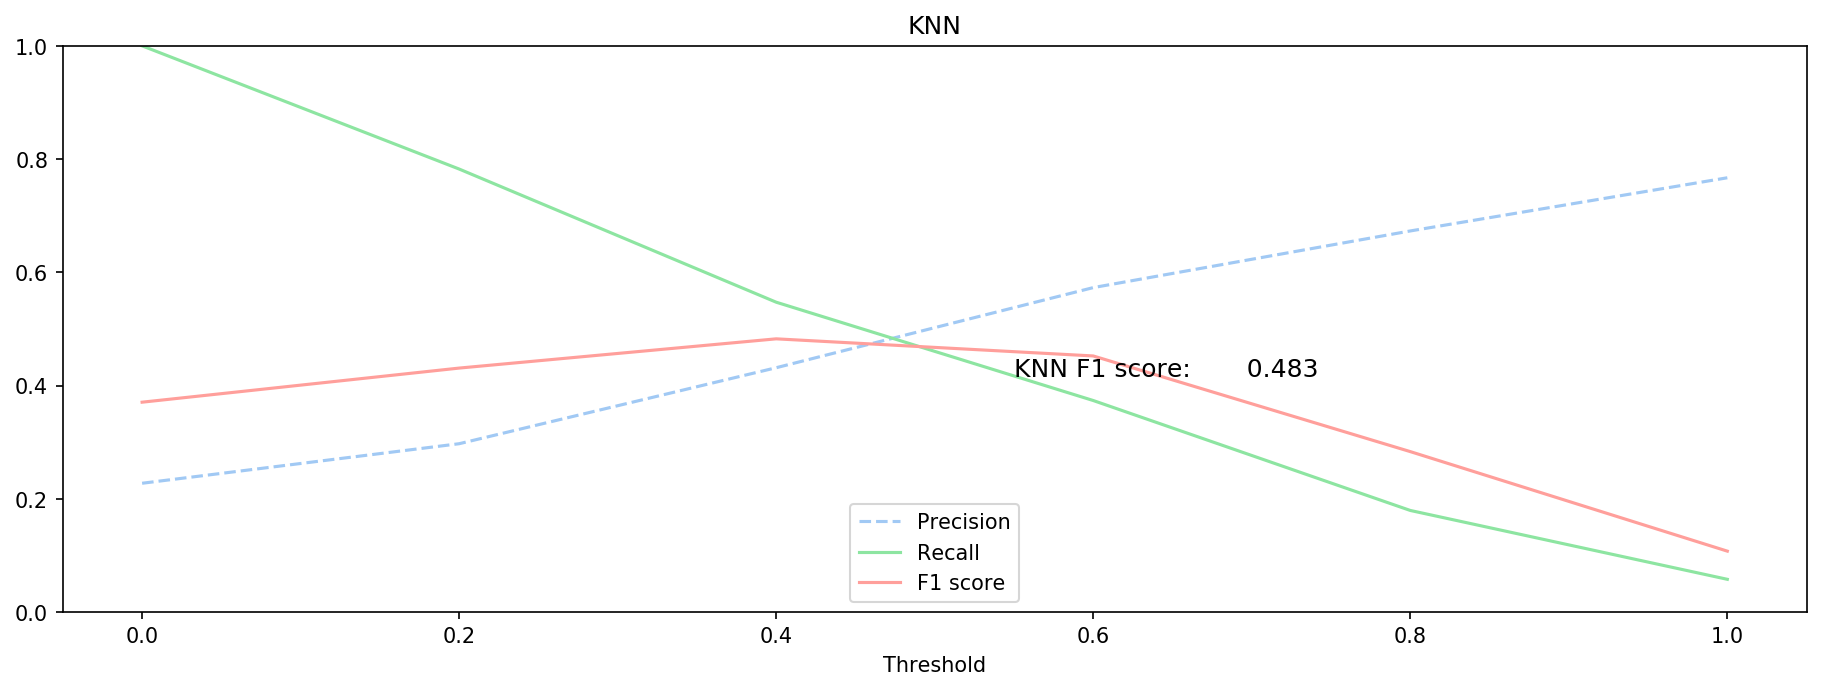

In [96]:
# Prepare all plotting function
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, 'g-', linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    f1=2*recalls*precisions/(precisions+recalls)
    plt.plot(thresholds, f1[:-1], "r-", label="F1 score")
    plt.xlabel("Threshold")
    plt.legend(loc="lower center")
    plt.ylim([0, 1])

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=12)
    plt.ylabel("Precision", fontsize=12)
    plt.axis([0, 1, 0, 1])

def estimate_prob(y_test_pred_prob, y_test):
    asscending_index = np.argsort(y_test_pred_prob)
    y_test_pred_prob = y_test_pred_prob[asscending_index]
    y_test_asscending = y_test.iloc[asscending_index]
    y_test_actu_prob = movingaverage (y_test_asscending)
    return y_test_pred_prob, y_test_actu_prob

def movingaverage (values: np.array, nwin: int=50)-> np.array:
    values_padded = np.pad(values, (nwin//2, nwin-1-nwin//2), mode='edge')
    weights = np.repeat(1.0, nwin)/nwin
    sma = np.convolve(values_padded, weights, 'valid')
    return sma
    
def plot_prob_scat(pred_prob: np.array, actu_prob: np.array, model: str)->None:
    r2 = r2_score(actu_prob, pred_prob)
    coeff = np.polyfit(pred_prob, actu_prob,1)
    plt.plot(actu_prob,coeff[0]*actu_prob+coeff[1], 
         color='black', linewidth=2)
    plt.text(0.05,1.7,'y={:.2f}+{:.2f}*x'.format(coeff[1],coeff[0]),
         color='black',size=8)
    plt.text(0.05,1.4,'R2={:.2f}'.format(r2),
         color='black',size=8)
    plt.scatter(pred_prob, 
                actu_prob,  
                c="b", 
                marker='o')
    plt.xlabel('Pred. prob.',size=8)
 
    plt.title('' + model, fontsize=8, y=-0.2)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.axis('equal')


    
y_test_pred_prob_knn = knn_clf.predict_proba(X_test)[:,1]


pl2, rl2, tl2 = precision_recall_curve(y_test, y_test_pred_prob_knn)



f1=2*pl2*rl2/(pl2+rl2)

mpl.rcParams['figure.dpi']= 150
plt.figure(figsize=(15,5))


plot_precision_recall_vs_threshold(pl2, rl2, tl2 );
plt.title('KNN')


txt_f1 = 'KNN F1 score:  %10.3f'%(np.nanmax(f1[:-1]))

#plt.text(0.55, 0.45, txt_f1, fontsize=12, va='top')
plt.text(0.55, 0.45, txt_f1, fontsize=12, va='top')



<Figure size 400x400 with 0 Axes>

Text(0.5, 1.0, 'Test data ROC')

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.55, 0.45, 'KNN AUC:       70.50%')

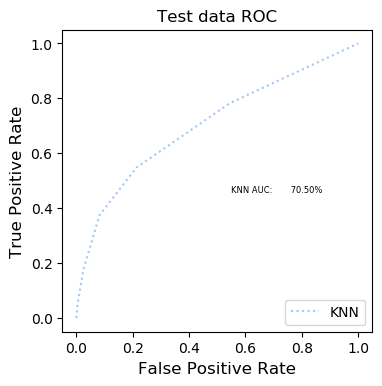

In [70]:
fp_l, tp_l, td_l = roc_curve(y_test, y_test_pred_prob_knn)

knn_lgt = roc_auc_score(y_test, y_test_pred_prob_knn)


mpl.rcParams['figure.dpi']= 100
plt.figure(figsize=(4,4))
plt.plot(fp_l, tp_l,'b:',label='KNN')

plt.title('Test data ROC')
plt.legend(loc='lower right')
tex_lgt = 'KNN AUC:  %10.2f%%'%(knn_lgt*100)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)

plt.text(0.55, 0.45, tex_lgt, fontsize=6, va='bottom')


## Logistic regression

In [14]:
from warnings import filterwarnings
from sklearn.model_selection import GridSearchCV
filterwarnings('ignore')

param_grid = [
    {'penalty':  ['l2'],
     'C':        [0.1, 1, 10, 100, 1000, 10000], 
     'max_iter': [10, 100, 1000, 10000],
     'tol':      [1e-4, 1e-5, 1e-6],
     'solver':   ['newton-cg']
    },
    {'penalty':  ['l1'],
     'C':        [0.1, 1, 10, 100, 1000, 2000], 
     'max_iter': [10, 100, 1000],
     'tol':      [1e-4, 1e-5, 1e-6],
     'solver':   ['saga']
    },
]
lgt_clf = LogisticRegression()
grid_search = GridSearchCV(lgt_clf, param_grid, cv=5, iid='True', 
                           scoring='f1')
grid_search.fit(X_train, y_train)

# Best params
print(grid_search.best_params_)

# Best estimator
lgt_clf_gd=grid_search.best_estimator_;

{'C': 10, 'max_iter': 10, 'penalty': 'l1', 'solver': 'saga', 'tol': 1e-05}


In [15]:
lgt_clf_gd.fit(X_train, y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=1e-05, verbose=0,
                   warm_start=False)

<Figure size 2250x750 with 0 Axes>

Text(0.5, 1.0, 'Logistic Regression')

Text(0.55, 0.45, 'Logsticgb F1 score:       0.539')

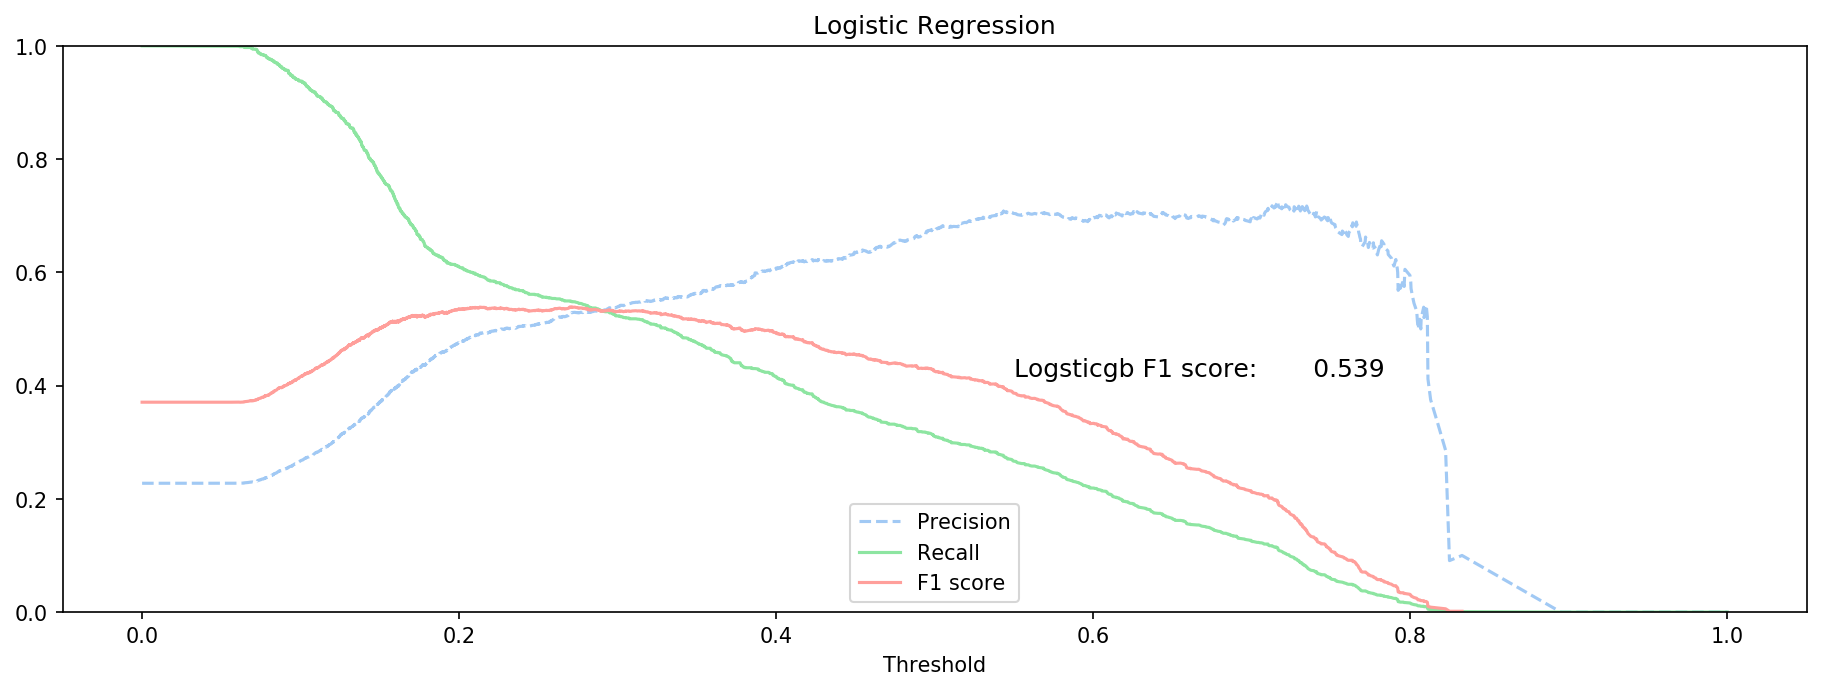

In [16]:



y_test_pred_prob_lgt_gd = lgt_clf_gd.predict_proba(X_test)[:,1]


pl2, rl2, tl2 = precision_recall_curve(y_test, y_test_pred_prob_lgt_gd)



f1=2*pl2*rl2/(pl2+rl2)

mpl.rcParams['figure.dpi']= 150
plt.figure(figsize=(15,5))


plot_precision_recall_vs_threshold(pl2, rl2, tl2 );
plt.title('Logistic Regression')


txt_f1 = 'Logsticgb F1 score:  %10.3f'%(np.nanmax(f1[:-1]))

#plt.text(0.55, 0.45, txt_f1, fontsize=12, va='top')
plt.text(0.55, 0.45, txt_f1, fontsize=12, va='top')


<Figure size 400x400 with 0 Axes>

Text(0.5, 1.0, 'Test data ROC')

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.55, 0.45, 'Logstic AUC:       77.06%')

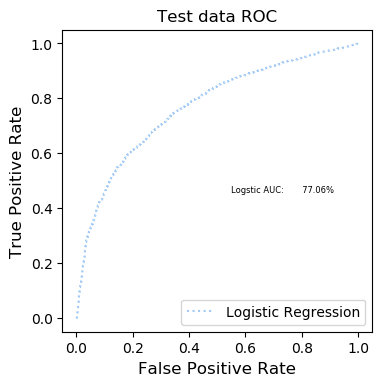

In [61]:
fp_l, tp_l, td_l = roc_curve(y_test, y_test_pred_prob_lgt_gd)

auc_lgt = roc_auc_score(y_test, y_test_pred_prob_lgt_gd)


mpl.rcParams['figure.dpi']= 100
plt.figure(figsize=(4,4))
plt.plot(fp_l, tp_l,'b:',label='Logistic Regression')

plt.title('Test data ROC')
plt.legend(loc='lower right')
tex_lgt = 'Logstic AUC:  %10.2f%%'%(auc_lgt*100)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)

plt.text(0.55, 0.45, tex_lgt, fontsize=6, va='bottom')


## XGboost

In [18]:
param_grid = {'objective':['binary:logistic'],            # Objective
              'learning_rate': [0.5, 0.6, 0.7, 0.8, 0.9], # `eta` value
              'max_depth':     [5, 6, 7, 8, 9],           # Tree Depth 
              'n_estimators':  [20, 40, 80, 160, 320],    # Boosting round 
              'silent':        [0]                        # Verbose 
             }
xgb_clf = xgb.XGBClassifier(random_state=42)
grid_search = GridSearchCV(xgb_clf, param_grid, n_jobs=5, cv=5, iid=True, 
                           scoring='f1')
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

# Best estimator
xgb_clf=grid_search.best_estimator_;

{'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 20, 'objective': 'binary:logistic', 'silent': 0}


In [19]:

xgb_clf.fit(X_train, y_train, eval_metric='auc', verbose=False,
            eval_set=[(X_test, y_test)], early_stopping_rounds=50)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.5, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=20, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=0, subsample=1, verbosity=1)

<Figure size 2250x750 with 0 Axes>

Text(0.5, 1.0, 'XGboost')

Text(0.55, 0.45, 'XGB F1 score:       0.552')

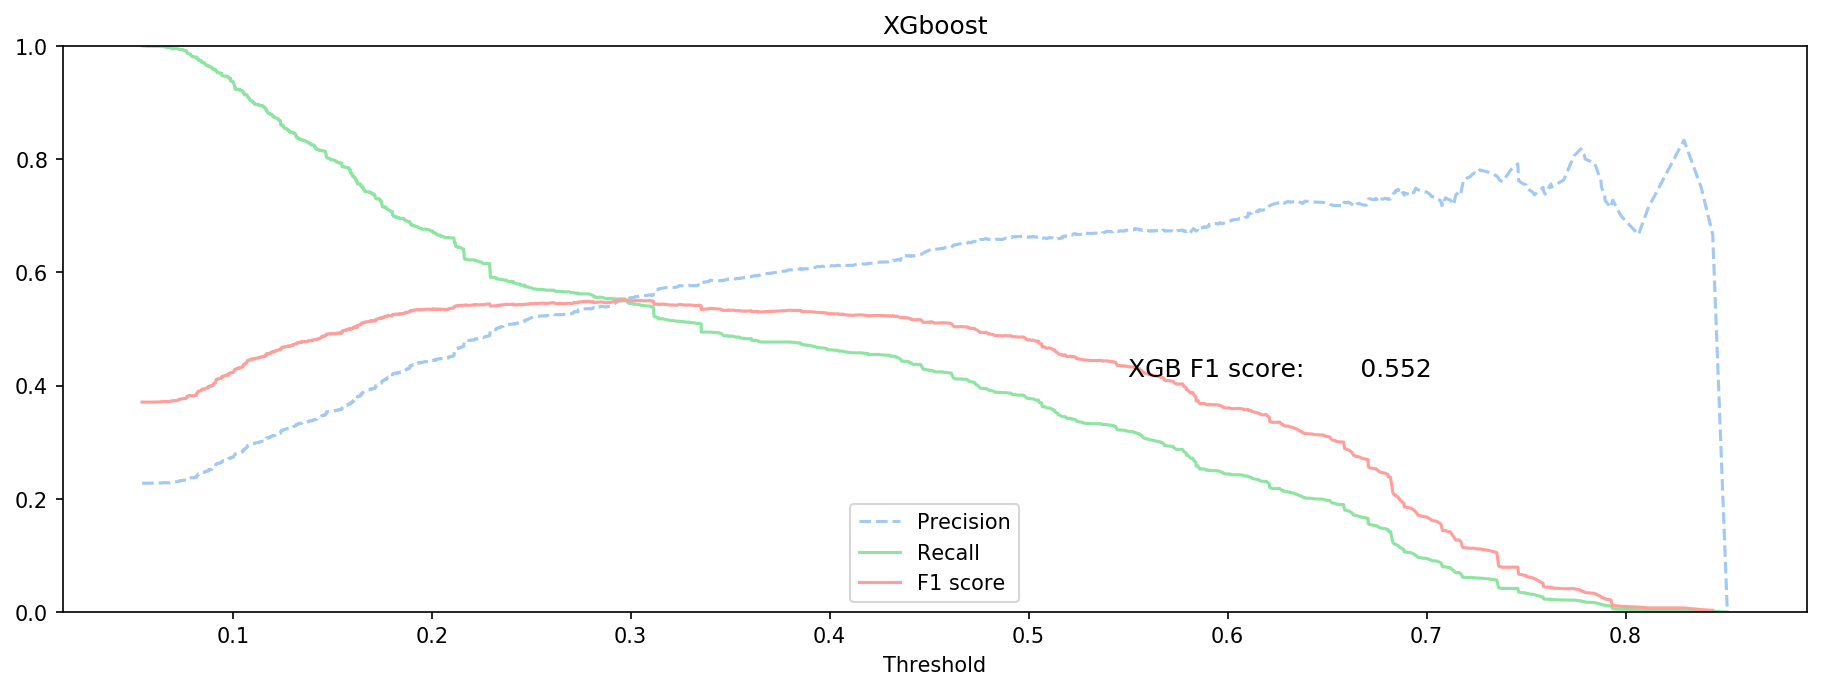

In [20]:
y_test_pred_prob_xgb_raw = xgb_clf.predict_proba(X_test)[:,1]

pl, rl, tl = precision_recall_curve(y_test, y_test_pred_prob_xgb_raw)

f1=2*pl*rl/(pl+rl)

mpl.rcParams['figure.dpi']= 150
plt.figure(figsize=(15,5))

plot_precision_recall_vs_threshold(pl, rl, tl );
plt.title('XGboost')

txt_f1 = 'XGB F1 score:  %10.3f'%(np.nanmax(f1[:-1]))

plt.text(0.55, 0.45, txt_f1, fontsize=12, va='top')



<Figure size 400x400 with 0 Axes>

Text(0.5, 1.0, 'Test data ROC')

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.55, 0.45, 'XGboost AUC:       77.77%')

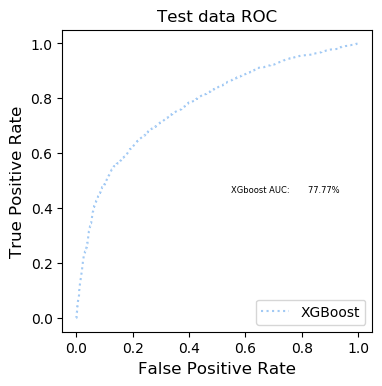

In [62]:
fp_l, tp_l, td_l = roc_curve(y_test, y_test_pred_prob_xgb_raw)

auc_lgt = roc_auc_score(y_test, y_test_pred_prob_xgb_raw)


mpl.rcParams['figure.dpi']= 100
plt.figure(figsize=(4,4))
plt.plot(fp_l, tp_l,'b:',label='XGBoost')

plt.title('Test data ROC')
plt.legend(loc='lower right')

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
tex_lgt = 'XGboost AUC:  %10.2f%%'%(auc_lgt*100)

plt.text(0.55, 0.45, tex_lgt, fontsize=6, va='bottom')

## Neural network

Without large computation power, I only can run single neural network test one by one instead of grid search. Here I show the best neural network results through tests.

In [22]:
import tensorflow.keras.initializers
import statistics
import tensorflow.keras
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.layers import LeakyReLU,PReLU
from tensorflow.keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.base import clone
import keras

Using TensorFlow backend.


In [53]:

def make_model1(dropout, lr, neuronCount):
    model = Sequential()    
    model.add(Dense(neuronCount, 
                    input_dim=X_train.shape[1], 
                    kernel_initializer = 'uniform',
                    activation='relu')) 
    model.add(Dense(neuronCount*2, kernel_initializer = 'uniform', activation='relu'))   
    model.add(Dropout(dropout)) 
    model.add(Dense(1,kernel_initializer = 'uniform', activation='sigmoid')) # Output
#     model.summary()
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=lr), metrics=['accuracy'])
    return model

ann_clf = make_model1(dropout = 0.4, lr = 0.01, neuronCount = 90)

ann_clf.summary()

ann_clf.fit(X_train, y_train, epochs=40,  verbose=True)


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 90)                2160      
_________________________________________________________________
dense_32 (Dense)             (None, 180)               16380     
_________________________________________________________________
dropout_13 (Dropout)         (None, 180)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 181       
Total params: 18,721
Trainable params: 18,721
Non-trainable params: 0
_________________________________________________________________
Train on 24000 samples
Epoch 1/40
24000/24000 [==============================] - 2s 86us/sample - loss: 0.4618 - accuracy: 0.8004
Epoch 2/40
24000/24000 [==============================] - 2s 79us/sample - loss: 0.4535 - accuracy: 0.8013
Epoch 3/40

<Figure size 2250x750 with 0 Axes>

Text(0.5, 1.0, 'ANN')

Text(0.25, 0.7, 'ANN F1 score:       0.548')

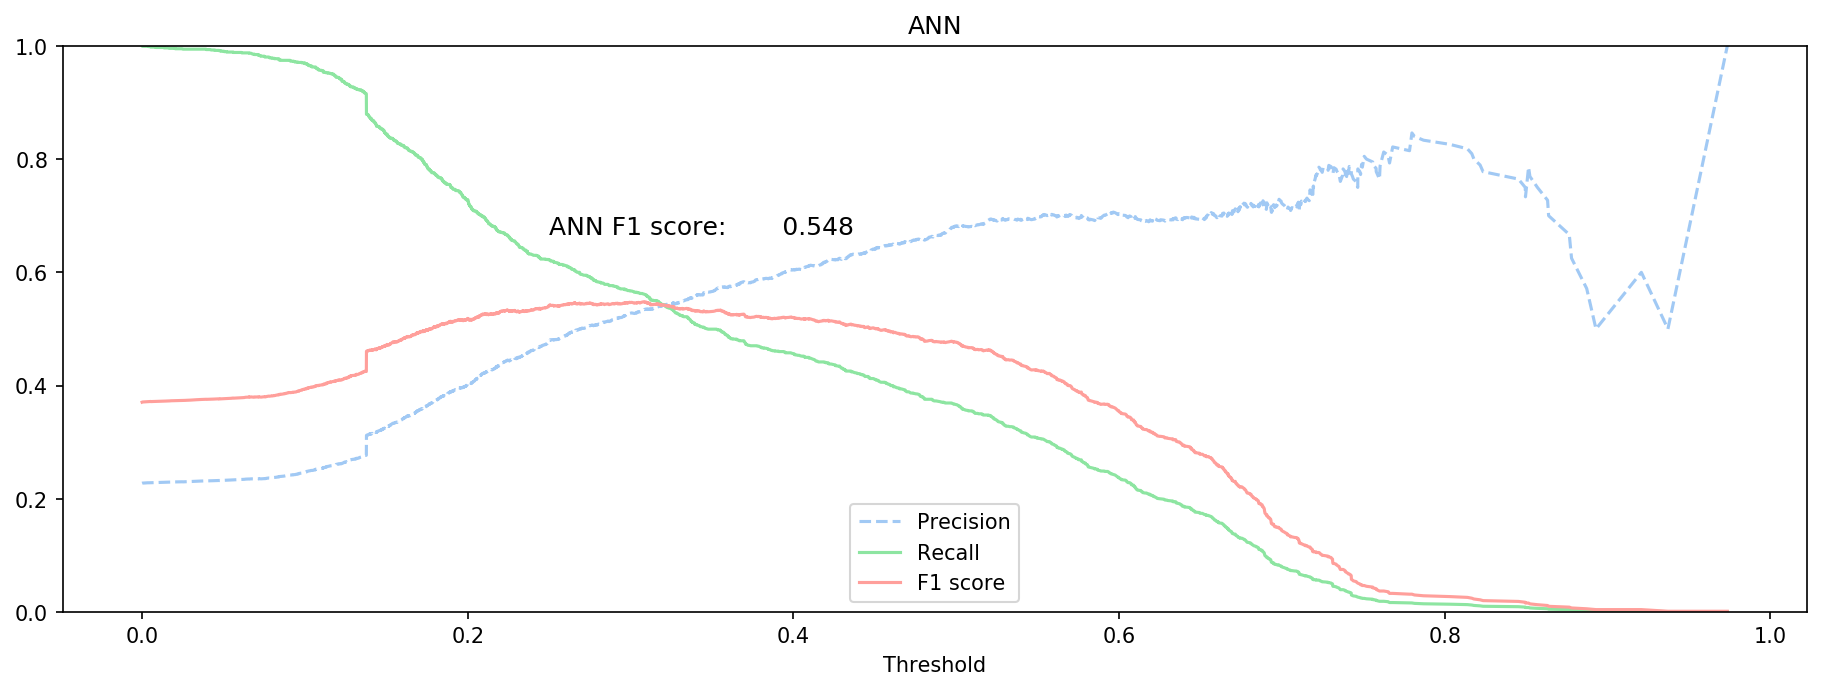

In [64]:
y_test_pred_prob_ann_raw = ann_clf.predict_proba(X_test)[:,0]

pl, rl, tl = precision_recall_curve(y_test, y_test_pred_prob_ann_raw)

f1=2*pl*rl/(pl+rl)

mpl.rcParams['figure.dpi']= 150
plt.figure(figsize=(15,5))

plot_precision_recall_vs_threshold(pl, rl, tl );
plt.title('ANN')

txt_f1 = 'ANN F1 score:  %10.3f'%(np.nanmax(f1[:-1]))

plt.text(0.25, 0.7, txt_f1, fontsize=12, va='top')


<Figure size 400x400 with 0 Axes>

Text(0.5, 1.0, 'Test data ROC')

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.55, 0.45, 'ANN AUC:      77.430%')

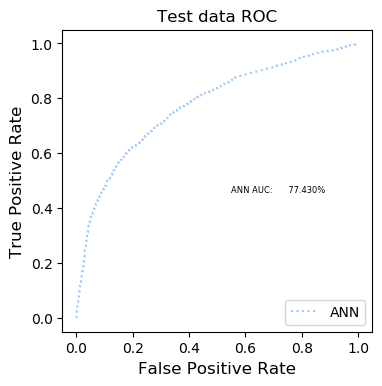

In [63]:
fp_l, tp_l, td_l = roc_curve(y_test, y_test_pred_prob_ann_raw)

auc_ann = roc_auc_score(y_test, y_test_pred_prob_ann_raw)
# acc_ann = accuracy_score(y_true = y_test, y_pred = ann_clf.predict(X_test))

mpl.rcParams['figure.dpi']= 100
plt.figure(figsize=(4,4))
plt.plot(fp_l, tp_l,'b:',label='ANN')

plt.title('Test data ROC')
plt.legend(loc='lower right')
tex_lgt = 'ANN AUC:  %10.3f%%'%(auc_ann*100)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)

plt.text(0.55, 0.45, tex_lgt, fontsize=6, va='bottom')
# plt.text(0.55, 0.45, tex_2, fontsize=6, va='bottom')


# Conclusion: comparison of four methods

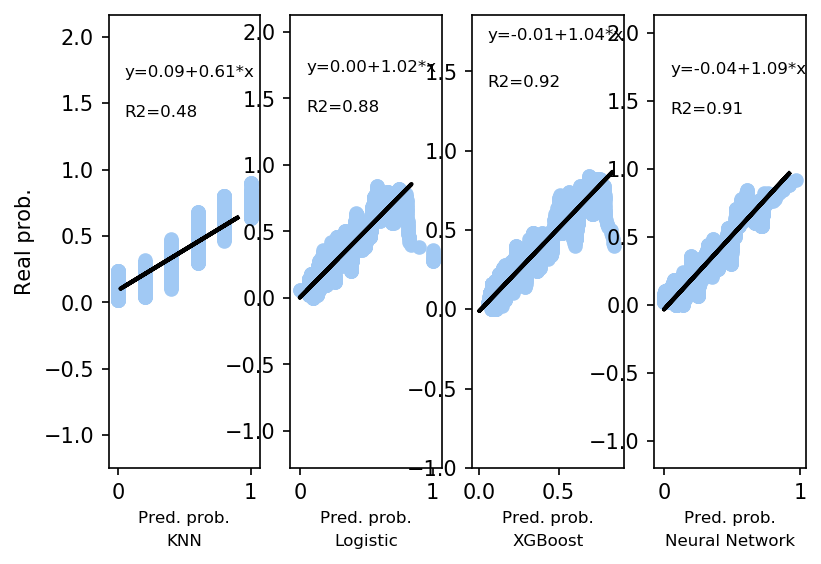

In [95]:
y_pred_knn, y_actu_knn = estimate_prob(y_test_pred_prob_knn, y_test)
y_pred_lgt, y_actu_lgt = estimate_prob(y_test_pred_prob_lgt_gd, y_test)
y_pred_xgb, y_actu_xgb = estimate_prob(y_test_pred_prob_xgb_raw, y_test)
y_pred_ann, y_actu_ann = estimate_prob(y_test_pred_prob_ann_raw, y_test)

plt.subplot(141)
plot_prob_scat(y_pred_knn, y_actu_knn, 'KNN');
plt.ylabel('Real prob.')
plt.subplot(142)
plot_prob_scat(y_pred_lgt, y_actu_lgt, 'Logistic');
plt.subplot(143)
plot_prob_scat(y_pred_xgb, y_actu_xgb, 'XGBoost');
plt.subplot(144)
plot_prob_scat(y_pred_ann, y_actu_ann, 'Neural Network');


The below table shows the comparison of four predictive models. Among them XGboost achieves the best scores. Meanwhile, neural network is very close to XGboost in terms of performance and come in the second out of three. 

| Metrics ||KNN || Logistic regression || XGBoost || Neural Network |
| --- || --- || --- || --- || --- |
| F1 Score  ||  0.4830 || 0.539 || 0.552 || 0.548 |
| AUC Score ||  70.50% ||77.03% || 77.77% || 77.43% |

Finally, it is worth mentioning that there is much room of improvement for neural network: 
- Run automated hyperparamter tuning for neural network method with more computation power.
- Current neural network only has three layers. Deep and novel network architecture can further help the performance.
- Further testing recurrent neural network and long short-term memory could be promising.